In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer,RobustScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error

from sklearn import set_config

Reading the input csv file

In [470]:
df = pd.read_csv('train_kaggle_house_price.csv')

In [471]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Seperating features and target variables and dropping the Id column

In [472]:
# Seperating the features(df_X) and target variable(y)
df_X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Dropping id column as it is not useful for modelling
df_X = df_X.drop('Id',axis=1)

df_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# Exploratory Data Analysis

### Missing values:
1) Find % of missing values in each column: find_percent_missing(dataset) function <br>
2) Select a threshold for % of missing values, above which we will drop the column (usually 25%)<br>
3) Find the columns that needs to be dropped<br>

In [473]:
# Function to find percentage of missing values in each column and to get column values having more than x%(threshold) of values missing
# percent_missing_sorted: list of tuples (column_name, % missing values)
# percent_missing_gt_30perc_cols: column names with more than 30% missing
# threshold: value above which we will drop column

threshold = 25
def find_percent_missing(df):
    percent_dict=((df.isnull().mean()*100).round(3)).to_dict()
    percent_missing_dict = {k:v for k,v in percent_dict.items() if v>0}
    percent_missing_sorted = sorted(percent_missing_dict.items(), key=lambda x:x[1],reverse=True)
    percent_missing_gt_30perc = [tup for tup in percent_missing_sorted if tup[1]>=threshold]
    percent_missing_gt_30perc_cols = [tup[0] for tup in percent_missing_gt_30perc]
    
    return percent_missing_sorted, percent_missing_gt_30perc_cols

In [474]:
# missing_cols: This variable shows columns having missing values along with % missing
# missing_cols_to_drop: This has a list of columns that needs to be dropped (since %missing is > threshold)

missing_cols, missing_cols_to_drop = find_percent_missing(df_X)


print(missing_cols_to_drop)
missing_cols

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


[('PoolQC', 99.521),
 ('MiscFeature', 96.301),
 ('Alley', 93.767),
 ('Fence', 80.753),
 ('FireplaceQu', 47.26),
 ('LotFrontage', 17.74),
 ('GarageType', 5.548),
 ('GarageYrBlt', 5.548),
 ('GarageFinish', 5.548),
 ('GarageQual', 5.548),
 ('GarageCond', 5.548),
 ('BsmtExposure', 2.603),
 ('BsmtFinType2', 2.603),
 ('BsmtQual', 2.534),
 ('BsmtCond', 2.534),
 ('BsmtFinType1', 2.534),
 ('MasVnrType', 0.548),
 ('MasVnrArea', 0.548),
 ('Electrical', 0.068)]

In [475]:
# df_temp = new df with missing columns dropped

df_temp = df_X.drop(missing_cols_to_drop, axis=1).copy()
print(df_temp.shape)
df_temp.head(3)


(1460, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal


df_temp is the dataset after dropping columns with % missing values greater than 25%

In [476]:
# df_temp.info()

#### Function to get the names of numerical, categorical and datetime columns : column_seggregator(dataset)
----------------------------------------------------------------------------
Categorical column: Column with d_type='Object'<br>
Categorical II column: Column with d_type='category'


In [477]:
# function to get column names of numerical, categorical and datetime columns
# select_dtypes: function used to select the columns or subset of a dataframe based on datatype

def column_seggregator(df):
    col_dict = {}
    col_dict['Categorical columns'] = df.select_dtypes(include='object').columns.to_list()
    col_dict['Numerical columns'] = df.select_dtypes(include='number').columns.to_list()
    col_dict['Datetime columns'] = df.select_dtypes(include='datetime').columns.to_list()
    col_dict['Categorical columns II'] = df.select_dtypes(include='category').columns.to_list()
    
    desc = f"#Categorical cols:{len(col_dict['Categorical columns'])},\
             #Numerical cols:{len(col_dict['Numerical columns'])},\
             #Datetime cols:{len(col_dict['Datetime columns'])},\
             #Categorical II cols:{len(col_dict['Categorical columns II'])}"
    return col_dict, desc

In [478]:
cols,desc = column_seggregator(df_temp)

In [479]:
print(desc)
print('*'*125)
print()
for col,lst in cols.items():
    print(f'{col}:{lst}')
    print()

#Categorical cols:38,             #Numerical cols:36,             #Datetime cols:0,             #Categorical II cols:0
*****************************************************************************************************************************

Categorical columns:['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

Numerical columns:['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',

#### Function to calculate the number of unique values and list of values in each categorical columns
---------------------------------------------------------------------------------------------------------
uniq_count_dict: A dicitonary with key=Column name, value=Total number(Count) of unique values in that column <br>
uniq_value_dict: A dicitonary with key=Column name, value=List of unique values in that column

In [480]:
# Function to find unique values in each column of categorical variables
# uniq_count_dict: A dicitonary with key=Column name, value=Total number(Count) of unique values in that column
# uniq_value_dict: A dicitonary with key=Column name, value=List of unique values in that column

def unique_values(df, col_list):
    uniq_value_dict={}
    uniq_count_dict={}
    total_uniq_values = 0
    for col in col_list:
        uniq_value_dict[col] = list(df[col].unique())
        uniq_count_dict[col] = df[col].nunique()
        total_uniq_values += df[col].nunique()
    
    print(f'No: of columns in initial dataset: {len(df.columns)}')
    print(f'Total number of unique values in {len(col_list)} categorical columns: {total_uniq_values}')
    print(f'Total number of columns if we perform OHE without drop_first=True: {len(df.columns)+total_uniq_values-len(col_list)}')
    print(f'Total number of columns if we perform OHE with drop_first=True: {len(df.columns)+total_uniq_values-len(col_list)*2}')
    
    return uniq_count_dict, uniq_value_dict

In [481]:
count, lst = unique_values(df_temp, cols['Categorical columns'])

No: of columns in initial dataset: 74
Total number of unique values in 38 categorical columns: 234
Total number of columns if we perform OHE without drop_first=True: 270
Total number of columns if we perform OHE with drop_first=True: 232


#### Shows unique values in each categorical column
----------------------------------------------------

In [482]:
for key,value in lst.items():
    print(key)
    print('*'*len(key))
    print(value)
    print()

MSZoning
********
['RL', 'RM', 'C (all)', 'FV', 'RH']

Street
******
['Pave', 'Grvl']

LotShape
********
['Reg', 'IR1', 'IR2', 'IR3']

LandContour
***********
['Lvl', 'Bnk', 'Low', 'HLS']

Utilities
*********
['AllPub', 'NoSeWa']

LotConfig
*********
['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']

LandSlope
*********
['Gtl', 'Mod', 'Sev']

Neighborhood
************
['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']

Condition1
**********
['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe']

Condition2
**********
['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe']

BldgType
********
['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']

HouseStyle
**********
['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin']

RoofSt

#### Temporarily replacing Nan values with 'Missing' tag in categorical data to plot its frequency distribution
-----------------------------------------
The resultant dataframe is df_temp_fill. This dataframe is used for plotting only

In [483]:
# Temporarily replacing NaN with 'Missing' tag in categorical data to plot its frequency distribution

df_temp_fill = df_temp.copy()
for col in cols['Categorical columns']:
    df_temp_fill[col].fillna('Missing',inplace=True)

In [484]:
def plot_categorical(df, col_list):
    for col in col_list:
        print(col.upper())
        print('*'*len(col))
        print(df[col].value_counts())
        plt.figure(figsize=(7,4.5))
        df[col].value_counts(normalize=True).plot.bar()
        plt.show()

MSZONING
********
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


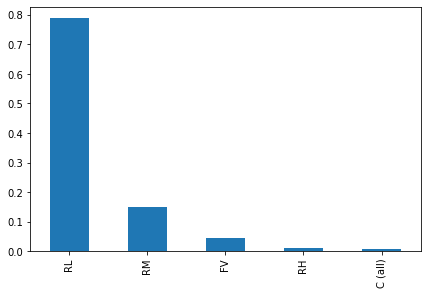

STREET
******
Pave    1454
Grvl       6
Name: Street, dtype: int64


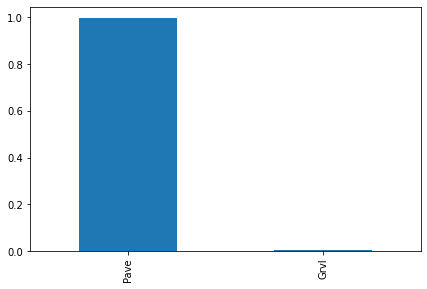

LOTSHAPE
********
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


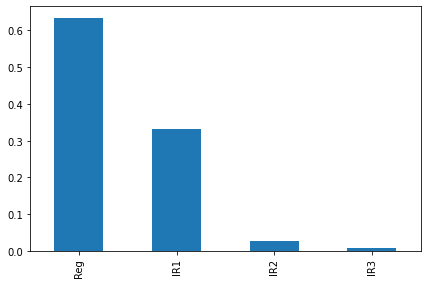

LANDCONTOUR
***********
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


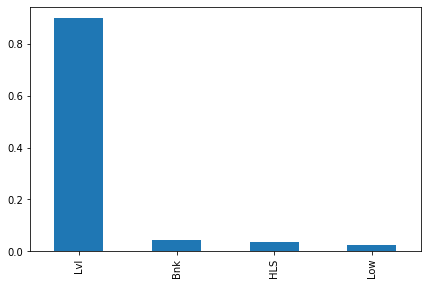

UTILITIES
*********
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


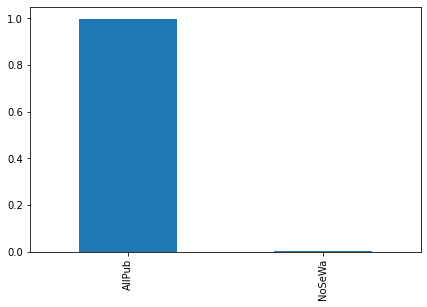

LOTCONFIG
*********
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


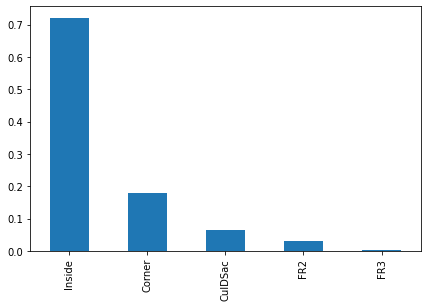

LANDSLOPE
*********
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


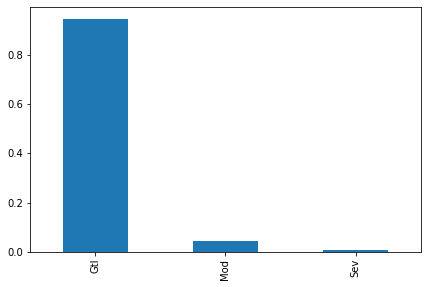

NEIGHBORHOOD
************
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


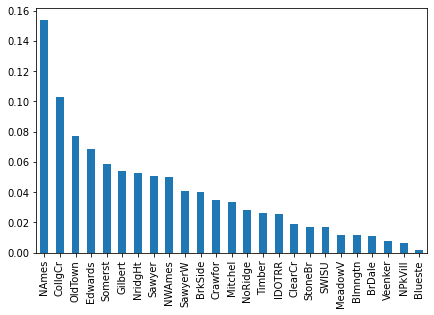

CONDITION1
**********
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


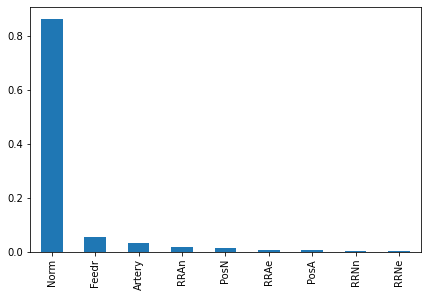

CONDITION2
**********
Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64


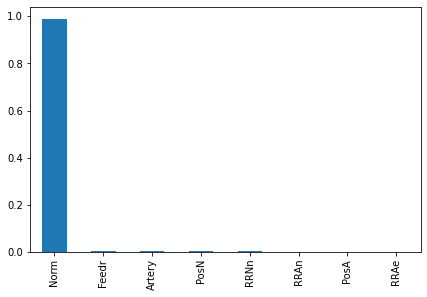

BLDGTYPE
********
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


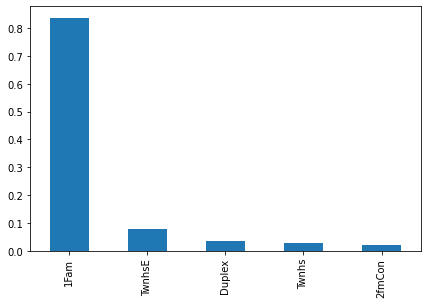

HOUSESTYLE
**********
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


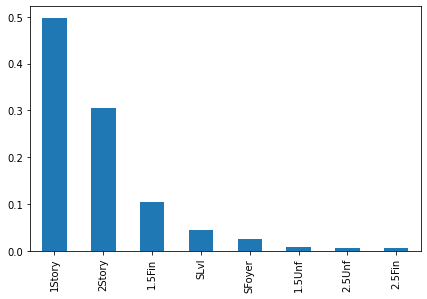

ROOFSTYLE
*********
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


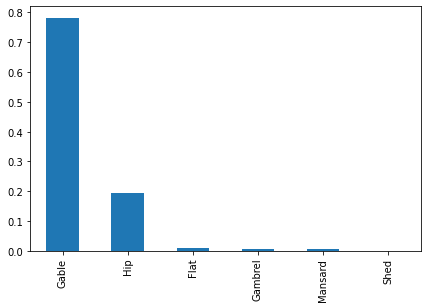

ROOFMATL
********
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64


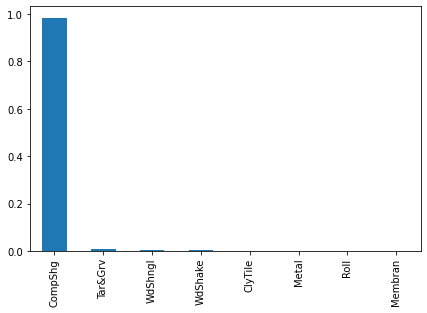

EXTERIOR1ST
***********
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
CBlock       1
AsphShn      1
ImStucc      1
Name: Exterior1st, dtype: int64


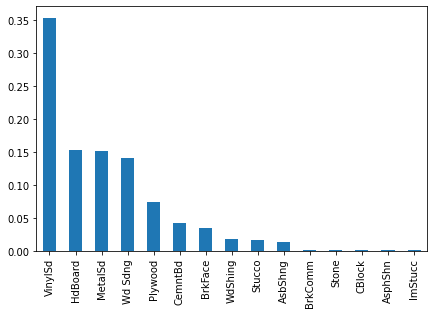

EXTERIOR2ND
***********
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64


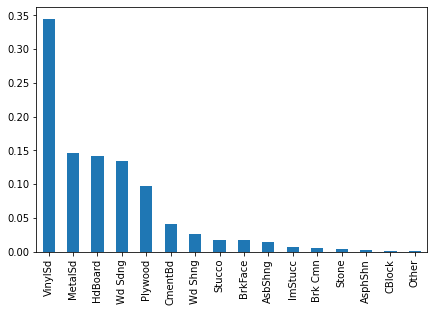

MASVNRTYPE
**********
None       864
BrkFace    445
Stone      128
BrkCmn      15
Missing      8
Name: MasVnrType, dtype: int64


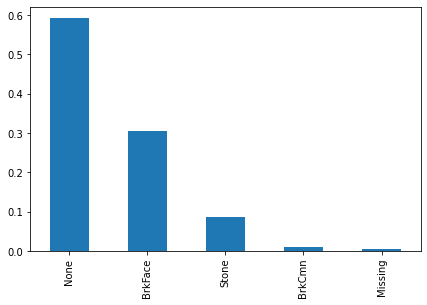

EXTERQUAL
*********
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


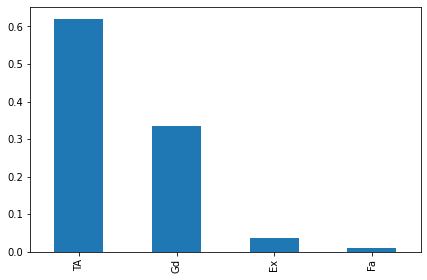

EXTERCOND
*********
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


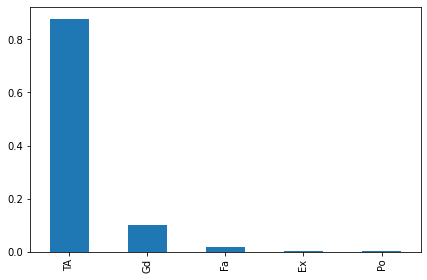

FOUNDATION
**********
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


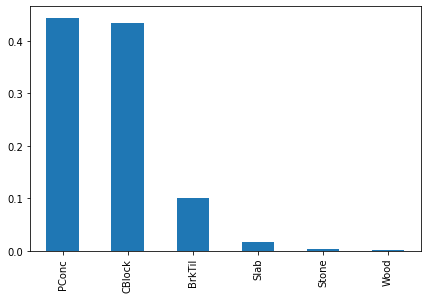

BSMTQUAL
********
TA         649
Gd         618
Ex         121
Missing     37
Fa          35
Name: BsmtQual, dtype: int64


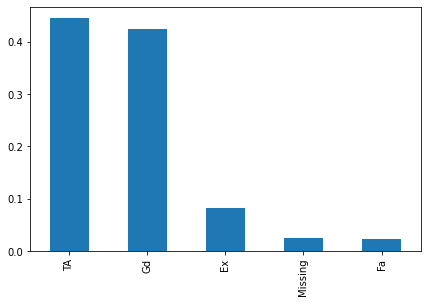

BSMTCOND
********
TA         1311
Gd           65
Fa           45
Missing      37
Po            2
Name: BsmtCond, dtype: int64


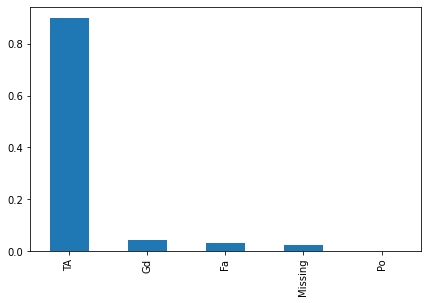

BSMTEXPOSURE
************
No         953
Av         221
Gd         134
Mn         114
Missing     38
Name: BsmtExposure, dtype: int64


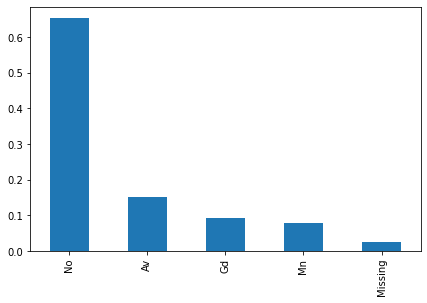

BSMTFINTYPE1
************
Unf        430
GLQ        418
ALQ        220
BLQ        148
Rec        133
LwQ         74
Missing     37
Name: BsmtFinType1, dtype: int64


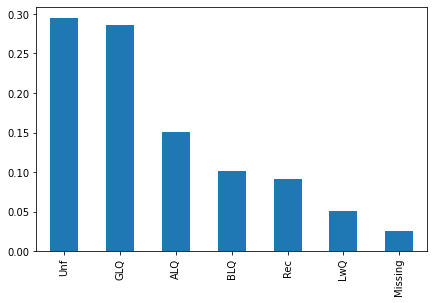

BSMTFINTYPE2
************
Unf        1256
Rec          54
LwQ          46
Missing      38
BLQ          33
ALQ          19
GLQ          14
Name: BsmtFinType2, dtype: int64


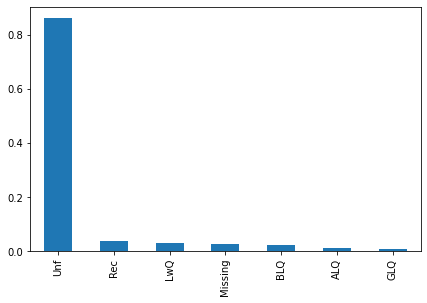

HEATING
*******
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


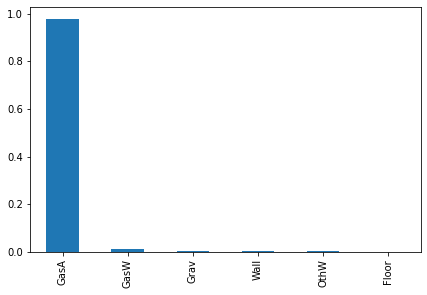

HEATINGQC
*********
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


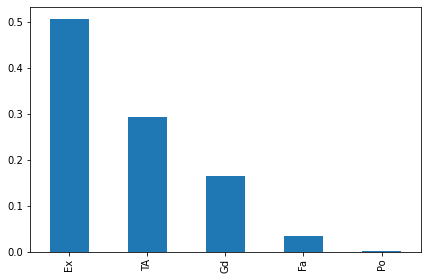

CENTRALAIR
**********
Y    1365
N      95
Name: CentralAir, dtype: int64


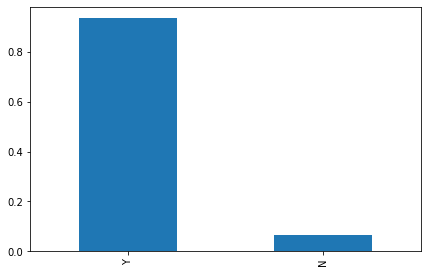

ELECTRICAL
**********
SBrkr      1334
FuseA        94
FuseF        27
FuseP         3
Mix           1
Missing       1
Name: Electrical, dtype: int64


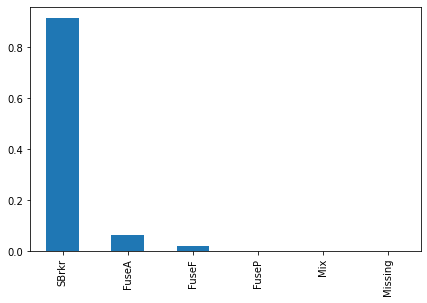

KITCHENQUAL
***********
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


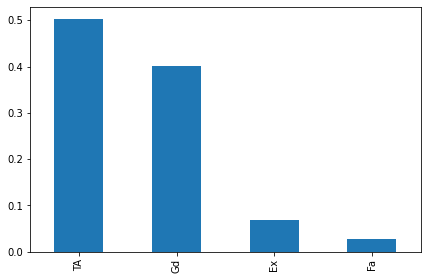

FUNCTIONAL
**********
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


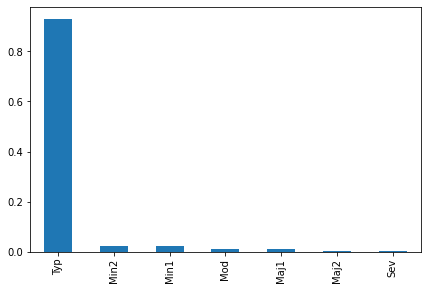

GARAGETYPE
**********
Attchd     870
Detchd     387
BuiltIn     88
Missing     81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


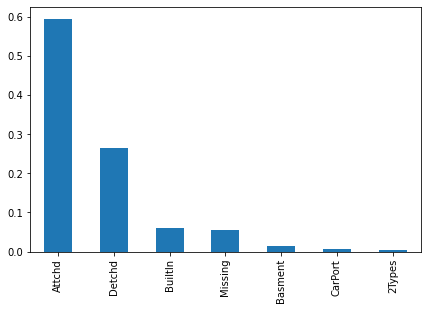

GARAGEFINISH
************
Unf        605
RFn        422
Fin        352
Missing     81
Name: GarageFinish, dtype: int64


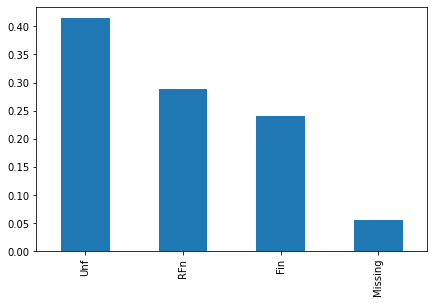

GARAGEQUAL
**********
TA         1311
Missing      81
Fa           48
Gd           14
Ex            3
Po            3
Name: GarageQual, dtype: int64


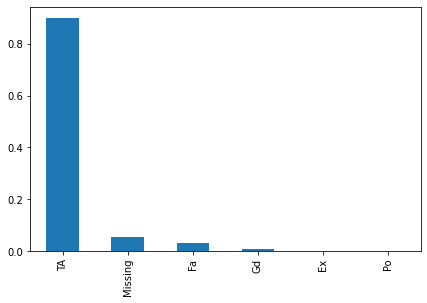

GARAGECOND
**********
TA         1326
Missing      81
Fa           35
Gd            9
Po            7
Ex            2
Name: GarageCond, dtype: int64


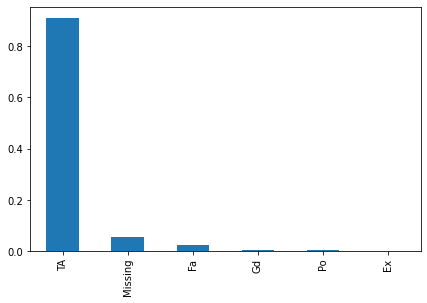

PAVEDDRIVE
**********
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64


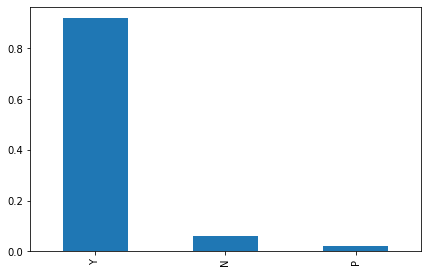

SALETYPE
********
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


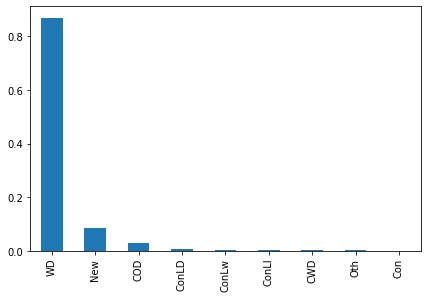

SALECONDITION
*************
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


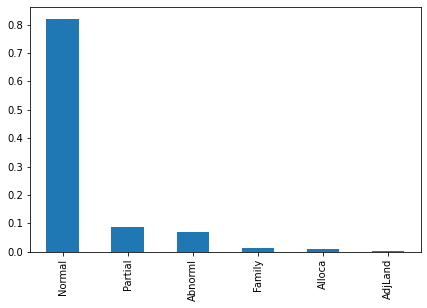

In [485]:
plot_categorical(df_temp_fill,cols['Categorical columns'])

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

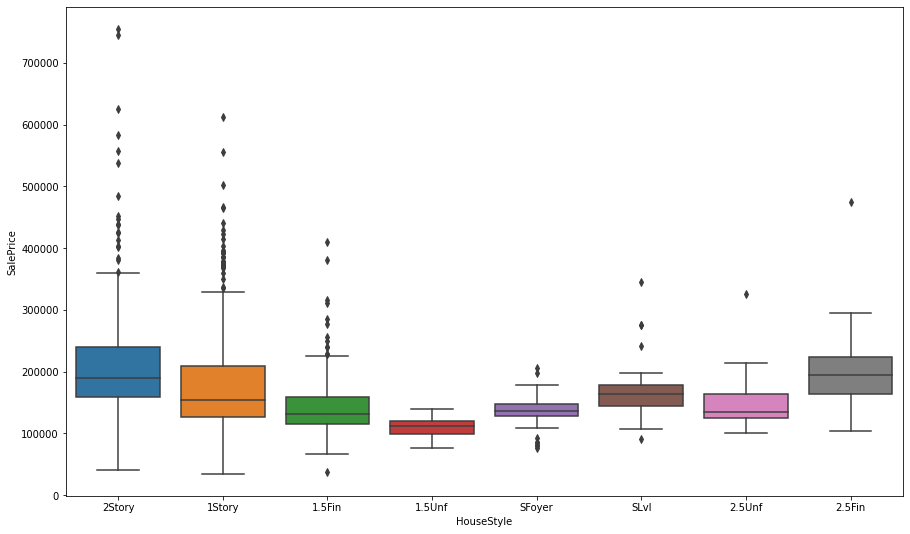

In [496]:
plt.figure(figsize=(15,9))
sns.boxplot(x="HouseStyle", y=df['SalePrice'], data=df_temp_fill)

#### Temporarily replacing Nan values with median value in categorical data to plot its histogram
-----------------------------------------
The resultant dataframe is df_temp_fill. This dataframe is used for plotting only

In [372]:
# Temporarily replacing NaN with median in numerical data to plot its heatmap

# df_temp_fill_num = df_temp.copy()
for col in cols['Numerical columns']:
    df_temp_fill[col].fillna(df_temp_fill[col].median(),inplace=True)

In [492]:
def plot_numerical(df, col_list):
    for col in col_list:
        print(col.upper())
        print('*'*len(col))
        if df[col].nunique()<=25:
            print(df[col].value_counts())
        plt.figure(figsize=(7,4.5))
        sns.displot(df,x=df[col], kind='kde',bw_adjust=2, height=4.5,aspect=1.5)
        plt.show()

MSSUBCLASS
**********
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


<Figure size 504x324 with 0 Axes>

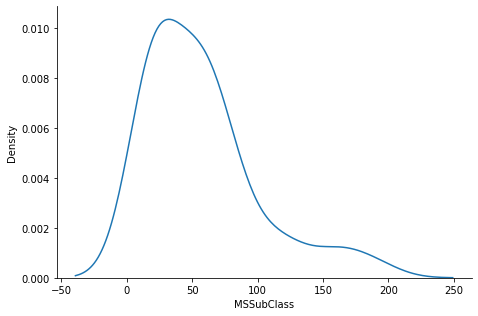

LOTFRONTAGE
***********


<Figure size 504x324 with 0 Axes>

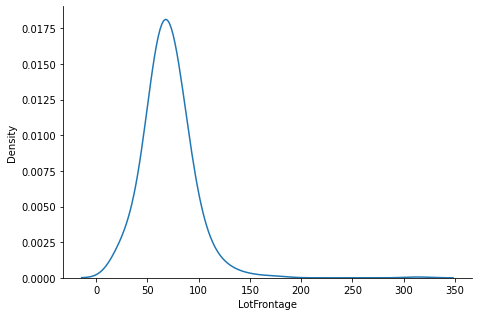

LOTAREA
*******


<Figure size 504x324 with 0 Axes>

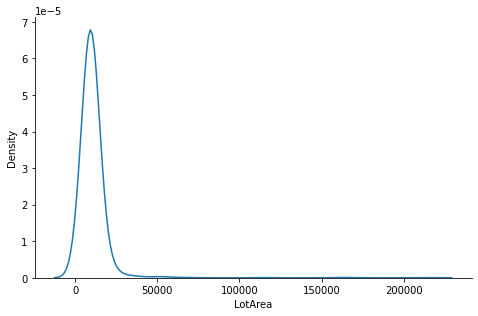

OVERALLQUAL
***********
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


<Figure size 504x324 with 0 Axes>

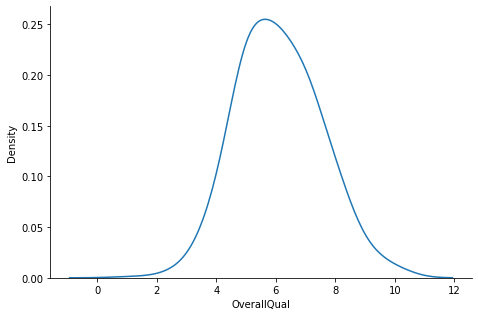

OVERALLCOND
***********
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64


<Figure size 504x324 with 0 Axes>

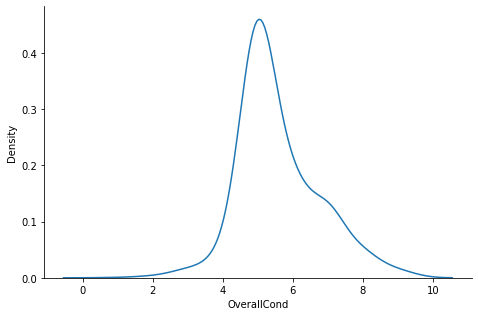

YEARBUILT
*********


<Figure size 504x324 with 0 Axes>

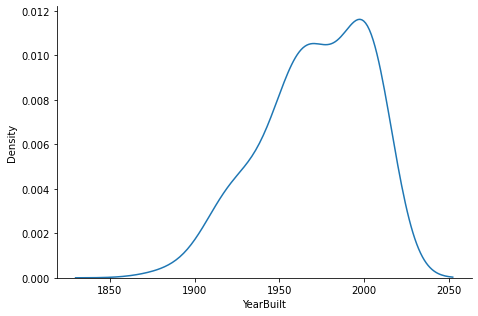

YEARREMODADD
************


<Figure size 504x324 with 0 Axes>

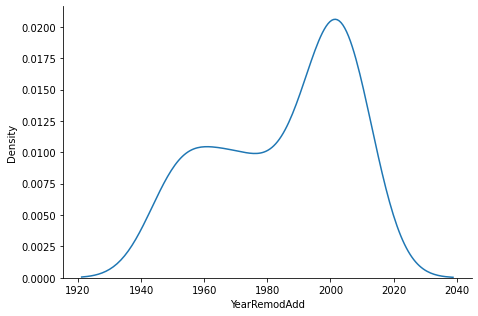

MASVNRAREA
**********


<Figure size 504x324 with 0 Axes>

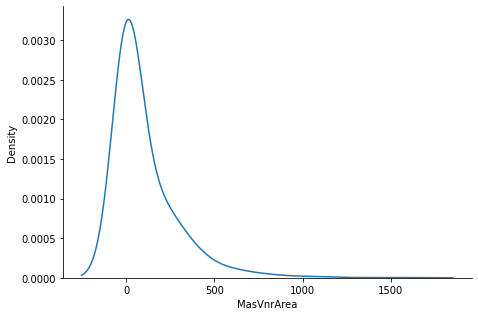

BSMTFINSF1
**********


<Figure size 504x324 with 0 Axes>

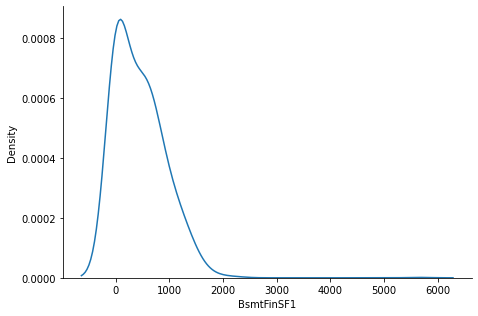

BSMTFINSF2
**********


<Figure size 504x324 with 0 Axes>

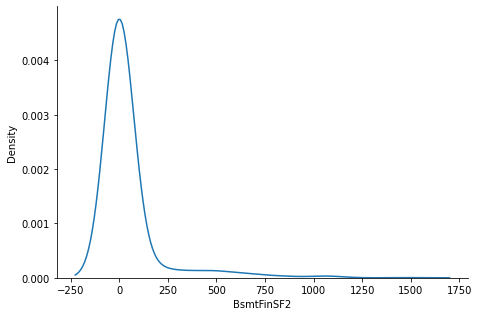

BSMTUNFSF
*********


<Figure size 504x324 with 0 Axes>

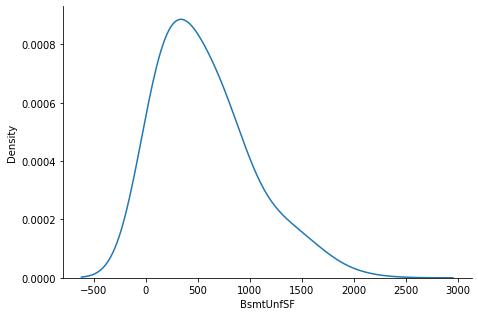

TOTALBSMTSF
***********


<Figure size 504x324 with 0 Axes>

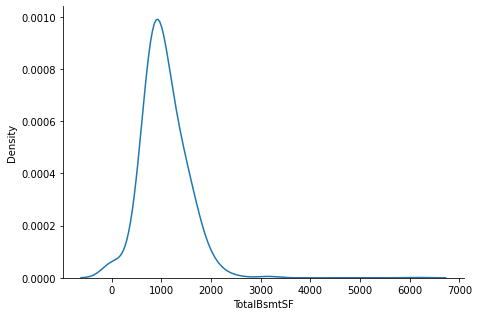

1STFLRSF
********


<Figure size 504x324 with 0 Axes>

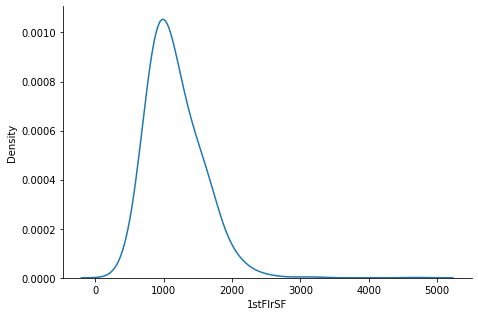

2NDFLRSF
********


<Figure size 504x324 with 0 Axes>

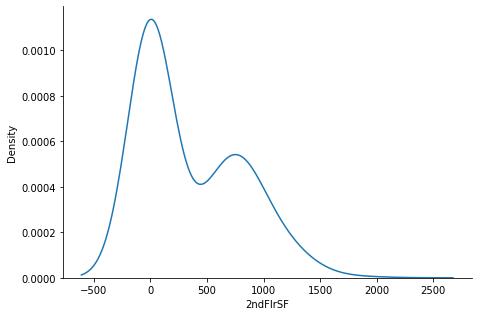

LOWQUALFINSF
************
0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64


<Figure size 504x324 with 0 Axes>

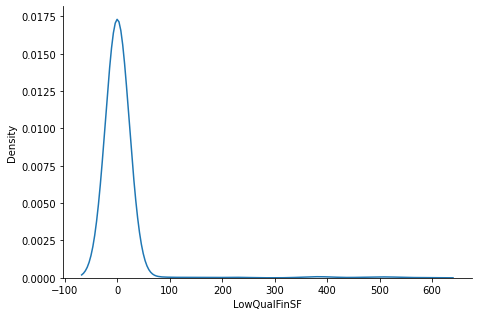

GRLIVAREA
*********


<Figure size 504x324 with 0 Axes>

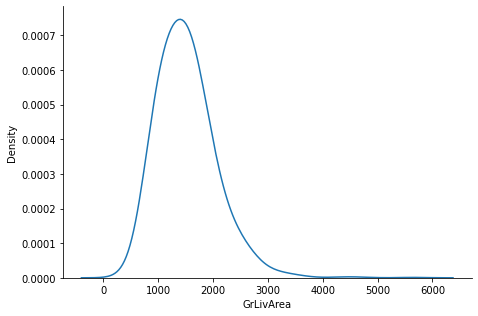

BSMTFULLBATH
************
0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64


<Figure size 504x324 with 0 Axes>

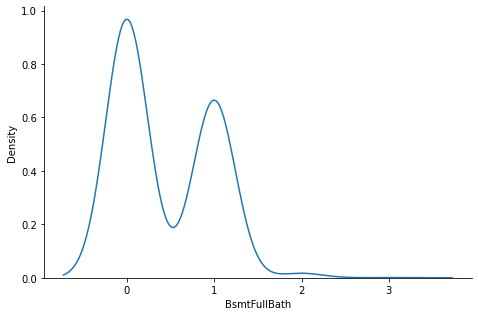

BSMTHALFBATH
************
0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64


<Figure size 504x324 with 0 Axes>

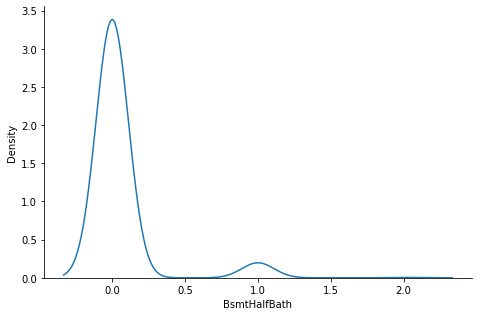

FULLBATH
********
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64


<Figure size 504x324 with 0 Axes>

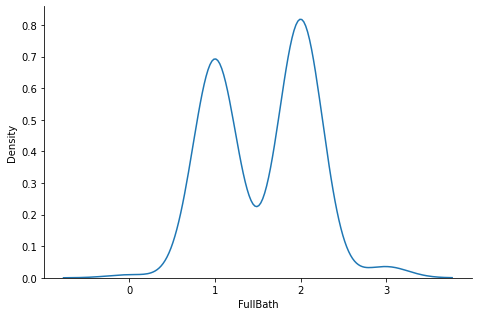

HALFBATH
********
0    913
1    535
2     12
Name: HalfBath, dtype: int64


<Figure size 504x324 with 0 Axes>

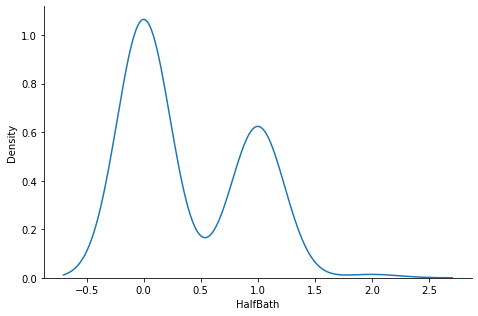

BEDROOMABVGR
************
3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64


<Figure size 504x324 with 0 Axes>

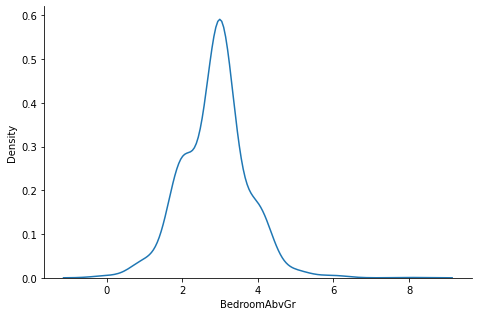

KITCHENABVGR
************
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64


<Figure size 504x324 with 0 Axes>

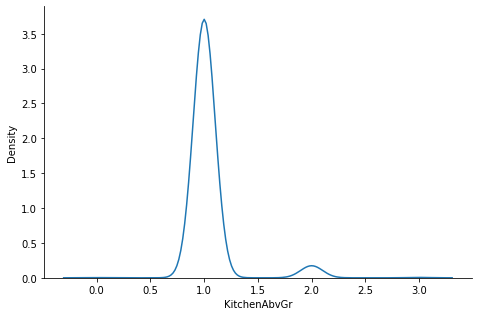

TOTRMSABVGRD
************
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64


<Figure size 504x324 with 0 Axes>

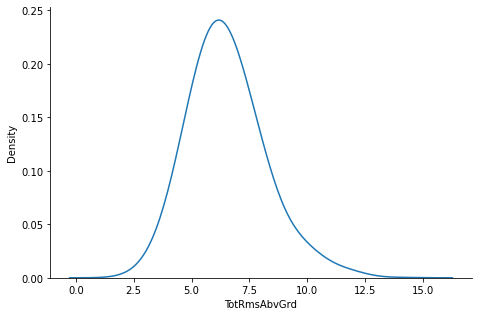

FIREPLACES
**********
0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64


<Figure size 504x324 with 0 Axes>

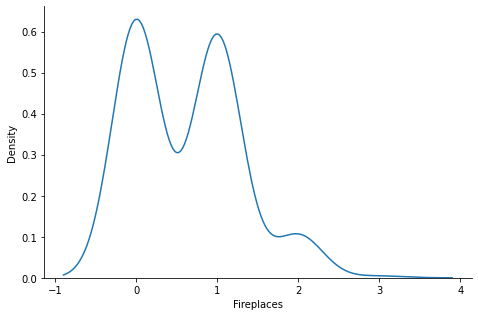

GARAGEYRBLT
***********


<Figure size 504x324 with 0 Axes>

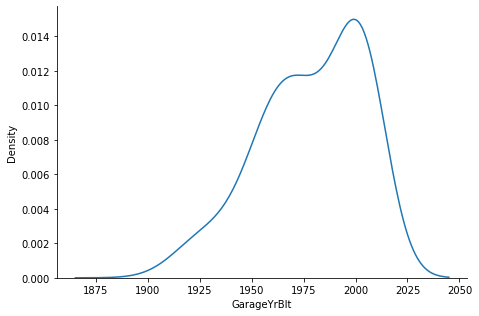

GARAGECARS
**********
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64


<Figure size 504x324 with 0 Axes>

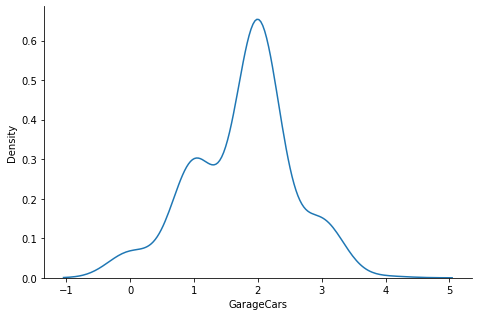

GARAGEAREA
**********


<Figure size 504x324 with 0 Axes>

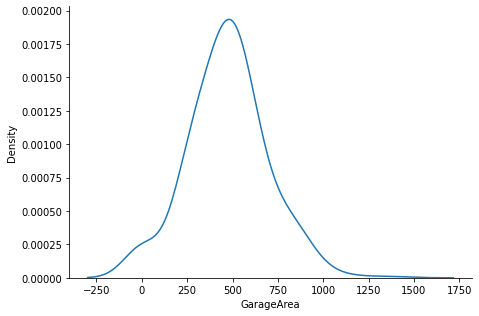

WOODDECKSF
**********


<Figure size 504x324 with 0 Axes>

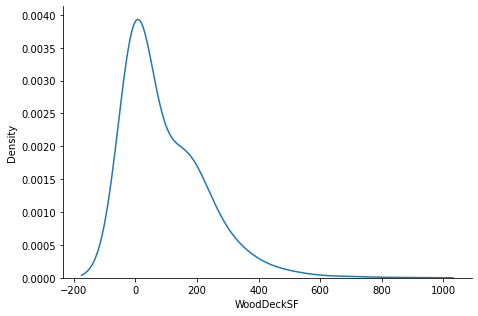

OPENPORCHSF
***********


<Figure size 504x324 with 0 Axes>

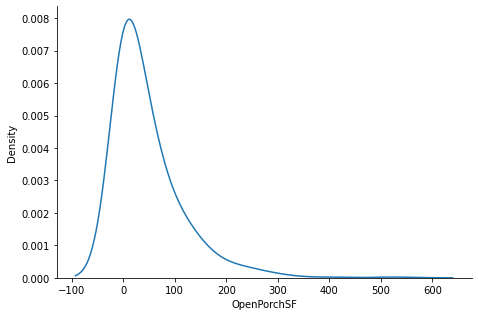

ENCLOSEDPORCH
*************


<Figure size 504x324 with 0 Axes>

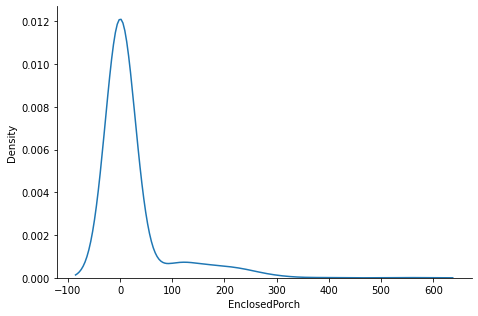

3SSNPORCH
*********
0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64


<Figure size 504x324 with 0 Axes>

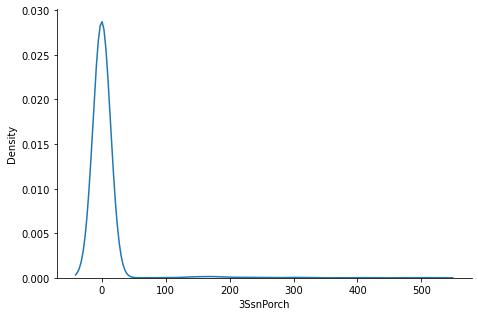

SCREENPORCH
***********


<Figure size 504x324 with 0 Axes>

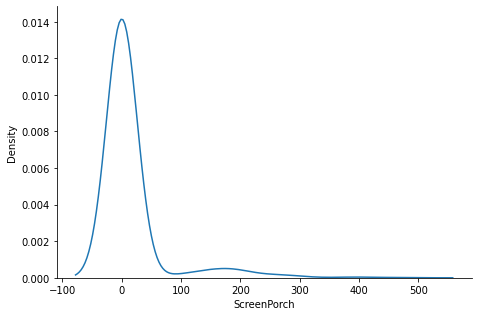

POOLAREA
********
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64


<Figure size 504x324 with 0 Axes>

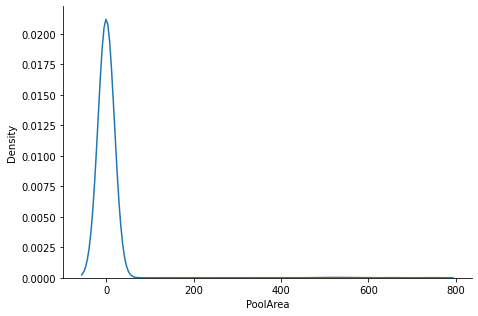

MISCVAL
*******
0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64


<Figure size 504x324 with 0 Axes>

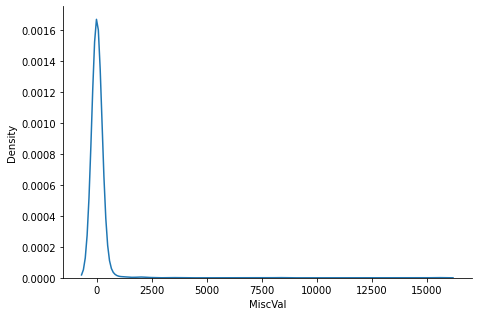

MOSOLD
******
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64


<Figure size 504x324 with 0 Axes>

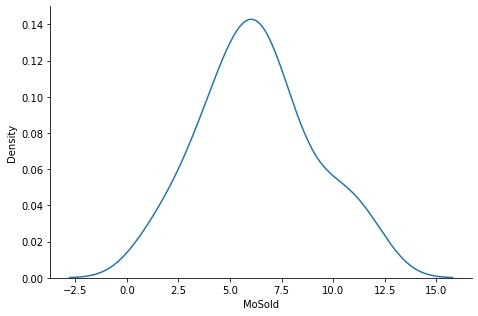

YRSOLD
******
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64


<Figure size 504x324 with 0 Axes>

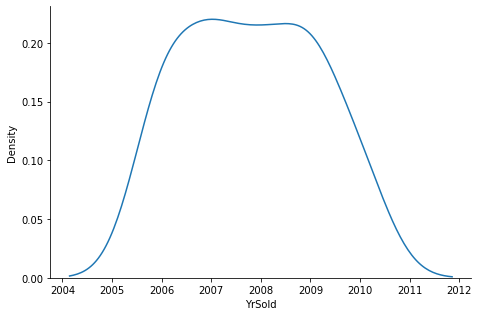

In [493]:
plot_numerical(df_temp_fill,cols['Numerical columns'])

## Inferences from these plots

From the kde plots we could see that most of the continuos(numerical) features are skewed. So we can try applying box-cox transform on them to convert them to near-normal distributions

## Correlation
-----------------

### Correlation between various features

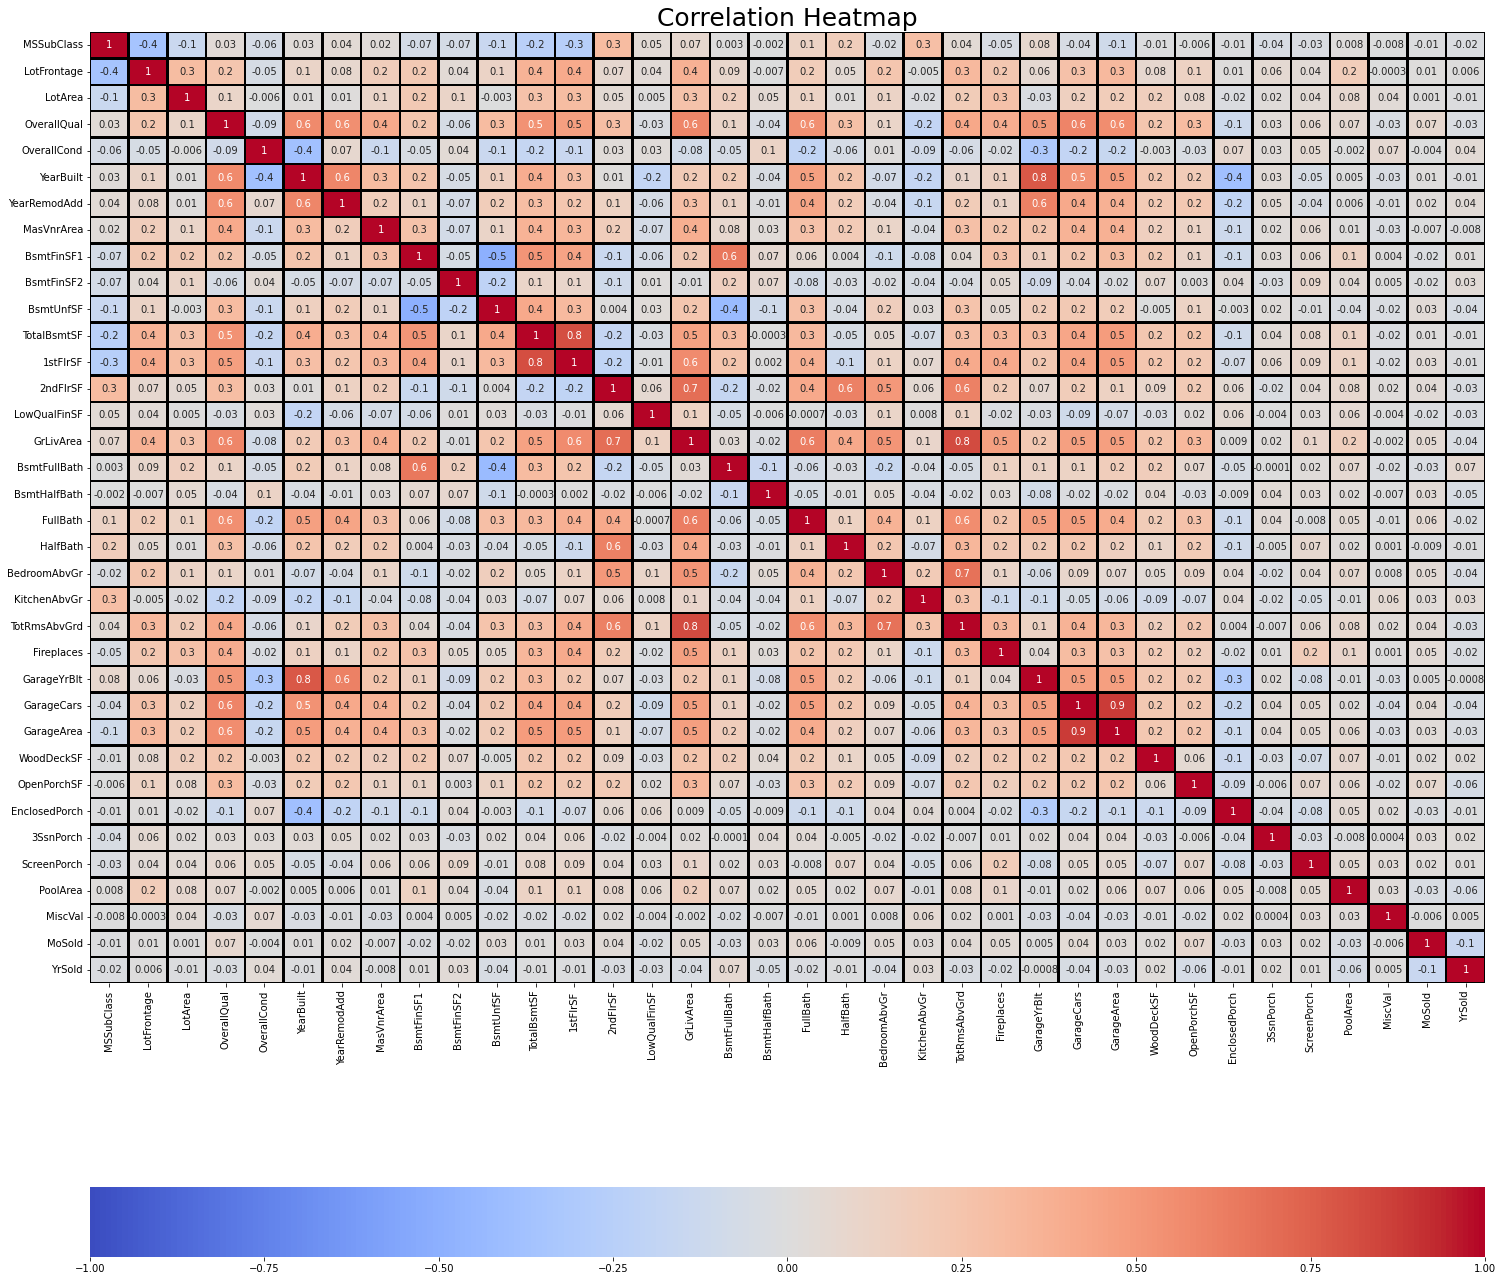

In [375]:
plt.figure(figsize=(25,25))
sns.heatmap(df_temp_fill.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g',cbar_kws= {'orientation': 'horizontal'},linewidths=1.5, linecolor='black')
plt.title('Correlation Heatmap', fontsize=25);

### Function to find columns having correlation value greater than sepcified threshold

In [376]:
# Function to find features with very high correlation values.
# corr_tup: Returned set of tuples which has list of features with high value of correlation as defined by the threshold variable


def find_corr(dataset, threshold):
    corr_tup = set()    #Tuples having column names with high correlation
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column                
                rowname = corr_matrix.columns[j]
                corr_tup.add((colname,rowname,corr_matrix.iloc[i, j]))
                
                
    return corr_tup

In [377]:
thresh = 0.7
corr_tup = find_corr(df_temp_fill, thresh)

NameError: name 'col_corr' is not defined

In [ ]:
corr_tup

### Function to find columns having correlation value greater than sepcified threshold
---------------------------------------------------------------------------------------------------
#### This is for correlation between features and target variable(Price)

In [ ]:
def targ_corr(dataset,target):
    corr = []
    for col in dataset.select_dtypes(include='number').columns:
        corr_value = dataset[col].corr(target)
        corr.append((col,corr_value))
    
    return sorted(corr, key=lambda x:x[1],reverse=False)

In [ ]:
corr_with_target = targ_corr(df_temp_fill, y)
corr_with_target

In [ ]:
def targ_corr_gt_threshold(lst,threshold):
    corr_gt_thresh = [(key,value) for key,value in lst if abs(value)>threshold]
    
    return corr_gt_thresh

In [ ]:
corr_gt_thresh = targ_corr_gt_threshold(corr_with_target,0.5)
corr_gt_thresh

## Inferences from Correlation heatmaps

# Model Building

In [417]:
df = pd.read_csv('train_kaggle_house_price.csv')

In [418]:
columns = df.columns
columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

This contains all the columns in the dataframe

In [419]:
cols, desc = column_seggregator(df)
desc

'#Categorical cols:43,             #Numerical cols:38,             #Datetime cols:0,             #Categorical II cols:0'

In [420]:
categorical_columns = cols['Categorical columns']
numerical_columns = cols['Numerical columns']

print('Categorical columns')
print('*'*len('Categorical columns'))
print(categorical_columns)
print()
print('Numerical columns')
print('*'*len('Numerical columns'))
print(numerical_columns)

Categorical columns
*******************
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numerical columns
*****************
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplace

This contains all the numerical and categorical variables. From this we have to drop columns as required

In [421]:
# columns_to_drop: conatins columns identified earlier having more thn 25% missing values and Id which is not useful for modelling
# X : Features columns
# y : Target variables

columns_to_drop = ['Id','PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

X = df.drop(columns_to_drop, axis=1).iloc[:,:-1]
y = df.iloc[:,-1]

Now we can find categorical and numerical columns from X

In [422]:
X.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal


In [423]:
column_dict = {}

for ind,col in enumerate(X.columns):
    column_dict[col] = ind
print(len(column_dict))
column_dict

74


{'1stFlrSF': 41,
 '2ndFlrSF': 42,
 '3SsnPorch': 66,
 'BedroomAbvGr': 49,
 'BldgType': 13,
 'BsmtCond': 29,
 'BsmtExposure': 30,
 'BsmtFinSF1': 32,
 'BsmtFinSF2': 34,
 'BsmtFinType1': 31,
 'BsmtFinType2': 33,
 'BsmtFullBath': 45,
 'BsmtHalfBath': 46,
 'BsmtQual': 28,
 'BsmtUnfSF': 35,
 'CentralAir': 39,
 'Condition1': 11,
 'Condition2': 12,
 'Electrical': 40,
 'EnclosedPorch': 65,
 'ExterCond': 26,
 'ExterQual': 25,
 'Exterior1st': 21,
 'Exterior2nd': 22,
 'Fireplaces': 54,
 'Foundation': 27,
 'FullBath': 47,
 'Functional': 53,
 'GarageArea': 59,
 'GarageCars': 58,
 'GarageCond': 61,
 'GarageFinish': 57,
 'GarageQual': 60,
 'GarageType': 55,
 'GarageYrBlt': 56,
 'GrLivArea': 44,
 'HalfBath': 48,
 'Heating': 37,
 'HeatingQC': 38,
 'HouseStyle': 14,
 'KitchenAbvGr': 50,
 'KitchenQual': 51,
 'LandContour': 6,
 'LandSlope': 9,
 'LotArea': 3,
 'LotConfig': 8,
 'LotFrontage': 2,
 'LotShape': 5,
 'LowQualFinSF': 43,
 'MSSubClass': 0,
 'MSZoning': 1,
 'MasVnrArea': 24,
 'MasVnrType': 23,
 'Misc

In [424]:
cols,desc = column_seggregator(X)
desc

'#Categorical cols:38,             #Numerical cols:36,             #Datetime cols:0,             #Categorical II cols:0'

In [425]:
categorical_columns = cols['Categorical columns']
numerical_columns = cols['Numerical columns']

print(f'Categorical columns: {len(categorical_columns)}')
print('*'*len('Categorical columns'))
print(categorical_columns)
print()
print(f'Numerical columns: {len(numerical_columns)}')
print('*'*len('Numerical columns'))
print(numerical_columns)

Categorical columns: 38
*******************
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

Numerical columns: 36
*****************
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeck

In [426]:
# To print the column indices from original dataset


cat_col_ind = [column_dict[col] for col in categorical_columns]
num_col_ind = [column_dict[col] for col in numerical_columns]

print(f'Categorical columns: {len(cat_col_ind)}')
print('*'*len('Categorical columns'))
print(cat_col_ind)
print()
print(f'Numerical columns: {len(num_col_ind)}')
print('*'*len('Numerical columns'))
print(num_col_ind)


Categorical columns: 38
*******************
[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 37, 38, 39, 40, 51, 53, 55, 57, 60, 61, 62, 72, 73]

Numerical columns: 36
*****************
[0, 2, 3, 15, 16, 17, 18, 24, 32, 34, 35, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 56, 58, 59, 63, 64, 65, 66, 67, 68, 69, 70, 71]


#### Splitting into train-test split
---

In [444]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=7)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1095, 74) (1095,) (365, 74) (365,)


### Creating components for a pipeline

We need to perform imputation(filling missing values), box-cox transform and standardisation on numerical variables and <br>
imputation, one hot encoding on categorical varibles. <br><br>
Then we need to transform the target variable to log scale to get better predictions

In [461]:
set_config(display='diagram')

In [462]:
# Simple Imputer for numerical variables: Replaces Nan with median
simple_imputer_numerical = SimpleImputer(strategy='median')

# Simple Imputer for categorical variables: Replaces Nan with 'Missing' tag
simple_imputer_categorical = SimpleImputer(strategy='constant', fill_value='Missing')

# Box-cox transform using sklearn's Power Transformer
# Need to try robust scaler and Quantile Transfoermer
box_cox = PowerTransformer(method='box-cox')

# Power Transformer has in-built option for Standardisation.
# Standard scaler
# scaler = StandardScaler()

# One Hot Encoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [463]:
# DONOT USE COLUMN TRANSFORMER LIKE THIS.
# Here I was trying to apply all transformations in a single Column Transforemer object.
# But the issue was the even after OHE, the output still had categorical variables which couldn't be used for modelling.
# Because each of the transformers's (Imputer for categorical,numerical),Scaler and OHE outputs were stacked by the ct object

# ct = ColumnTransformer([('simp_imp_num', SimpleImputer(strategy='median'),numerical_columns),
#                         ('box-cox', PowerTransformer(), numerical_columns),
#                         ('simp_imp_cat', SimpleImputer(strategy='constant', fill_value='Missing'),categorical_columns),
#                         ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)],
#                         remainder='drop')

In [464]:
# Column transformer for imputing

ct_imputer = ColumnTransformer([('imputer_num', SimpleImputer(strategy='median'),num_col_ind),
                                ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Missing'),cat_col_ind)],
                              remainder='passthrough')

In [467]:
# Column transformer for PowerTransformer and OneHotEncoder
# Here we cannot use OHE with drop='first' because there are certain categorical columns with very less data points in a category.
# So wehn doing train_test_split sometimes we will get some category in test set which was not there in train set which will rasie error.

# ct_scaler_ohe = ColumnTransformer([('box-cox', PowerTransformer(standardize=True), list(range(0,36))),
#                                    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='error'), list(range(36,74)))],
#                                     remainder='passthrough')



ct_scaler_ohe = ColumnTransformer([('box-cox', PowerTransformer(standardize=True), list(range(0,36))),
                                   ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), list(range(36,74)))],
                                    remainder='passthrough')




# ct_scaler_ohe = ColumnTransformer([('scaler', RobustScaler(), list(range(0,36))),
#                                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), list(range(36,74)))],
#                                     remainder='passthrough')

In [468]:
p = Pipeline([('imputer',ct_imputer),('scaler_ohe',ct_scaler_ohe)])
train_p = p.fit_transform(X_train)
test_p = p.transform(X_test)

C:\Users\vinay\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\vinay\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [451]:
# Model

lr = LinearRegression()

en = ElasticNet()

In [452]:
# Pipeline

# pipe = Pipeline([('imputer',ct_imputer),('scaler_ohe',ct_scaler_ohe),('reg-model',lr)])
pipe = Pipeline([('imputer',ct_imputer),('scaler_ohe',ct_scaler_ohe),('en-model',en)])

In [453]:
# Transforming target variable for regression

tt = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)
model = tt.fit(X_train,y_train)

C:\Users\vinay\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\vinay\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [454]:
# model = pipe.fit(X_train,y_train)

In [455]:
print(f'Train accuracy: {model.score(X_train,y_train)}')
print(f'Test accuracy: {model.score(X_test,y_test)}')

Train accuracy: -0.03174863363247793
Test accuracy: -0.045626214539468135


In [456]:
cross_val_score(model,X_train,y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=3,error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


array([-82513.12666679, -77964.33364551, -74725.82203332, -67222.18543052,
       -91912.60675766])

In [457]:
# print(f'Train accuracy: {mean_squared_log_error(y_train, model.predict(X_train))}')
# print(f'Test accuracy: {mean_squared_log_error(y_test, model.predict(X_test))}')

In [458]:
y_pred = pd.DataFrame(model.predict(X_test))

In [459]:
y_pred[y_pred[0]<=0]

,0


### To make predictions and save that to o/p file

In [460]:
df_test = pd.read_csv('test_kaggle_house_price.csv')

df_test_id = df_test.loc[:,'Id'] #Collecting all the id's from test data 

df_test_final = df_test.iloc[:,1:].drop(missing_cols_to_drop, axis=1) #Getting all features other than 'Id'

pred = model.predict(df_test_final) #Making predictions

final_df = pd.DataFrame({'Id': df_test_id, 'SalePrice': pred}) #Converting predictions and 'Id' to a dataframe
final_df.to_csv('Prediction_box_cox_elastic_net.csv',index=False) #Writing predicitons to an output file

## New feature transformations